# Monte Carlo Markov Chain sampling of COVID-19 infections

#### Author: leebond
#### Date: Feb 2020

In [1]:
import numpy as np
import scipy
import scipy.stats
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import os, re, sys

# from helper_fun_model import *
from mcmcHelperFunctions import *

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

## Data source
#### source JHU

In [2]:
## Load data 
df = pd.read_csv("../data/daily_time_series_data_JHU.csv")

"""
Data Cleaning 
"""
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
df.tail(3) # check new

,Province,Country,Date,Confirmed,Deaths,Recovered
2023,"San Antonio, TX",United States,2020-02-21,1.0,0,0
2024,"Seattle, WA",United States,2020-02-21,1.0,0,1
2025,"Tempe, AZ",United States,2020-02-21,1.0,0,0


# Case 1: Simulate Hubei infection numbers

In [3]:
case = df[df['Country']=='China'] # get all of China's infection numbers
case = case.groupby('Date').agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'}).reset_index()

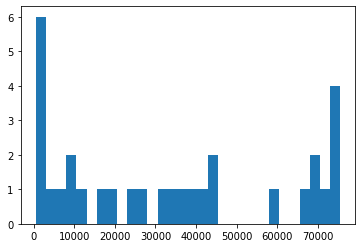

In [4]:
plt.hist(case['Confirmed'], bins = 30)
plt.show()

#### Using the daily change in infection number as a random variable we want to model
- the change in the infection numbers from day to day can tell us the force of infection per day. In other words, it can also be thought of as the infection rate which we could model as a random variable.
- to do so i simply do `diff()` which takes the first 'lag' of the infection column. Notice that the first row will not have any number since there is no 'lag'. Therefore, I fill the first record as 1 for simplicity yet it can't be 0 since there 'should' be some kind of new infection from day to day.

In [5]:
case['new infected'] = case['Confirmed'].diff().fillna(1)

In [6]:
case.head(10)

,Date,Confirmed,Deaths,Recovered,new infected
0,2020-01-22,547.0,17,28,1.0
1,2020-01-23,639.0,18,30,92.0
2,2020-01-24,916.0,26,36,277.0
3,2020-01-25,1399.0,42,39,483.0
4,2020-01-26,2062.0,56,49,663.0
5,2020-01-27,2863.0,82,58,801.0
6,2020-01-28,5494.0,131,101,2631.0
7,2020-01-29,6070.0,133,120,576.0
8,2020-01-30,8124.0,171,135,2054.0
9,2020-01-31,9783.0,213,214,1659.0


In [7]:
case.shape

(31, 5)

## EDA

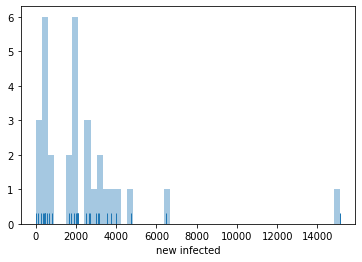

In [8]:
sb.distplot(case['new infected'], bins=50, kde=False, rug=True)

### Creating a gamma fit to the data
- the belief distribution is that the infection rate follows a gamma distribution.
- A gamma distribution is continuous, does not take on negative values and its flexible since it takes on two parameters; shape and scale
- several research papers have used gamma to model infection rates (google abit and you will see many using gamma)

In [9]:
mu = case['new infected'].mean()
sigma = case['new infected'].std()
mu, sigma

(2416.967741935484, 2808.6664271366812)

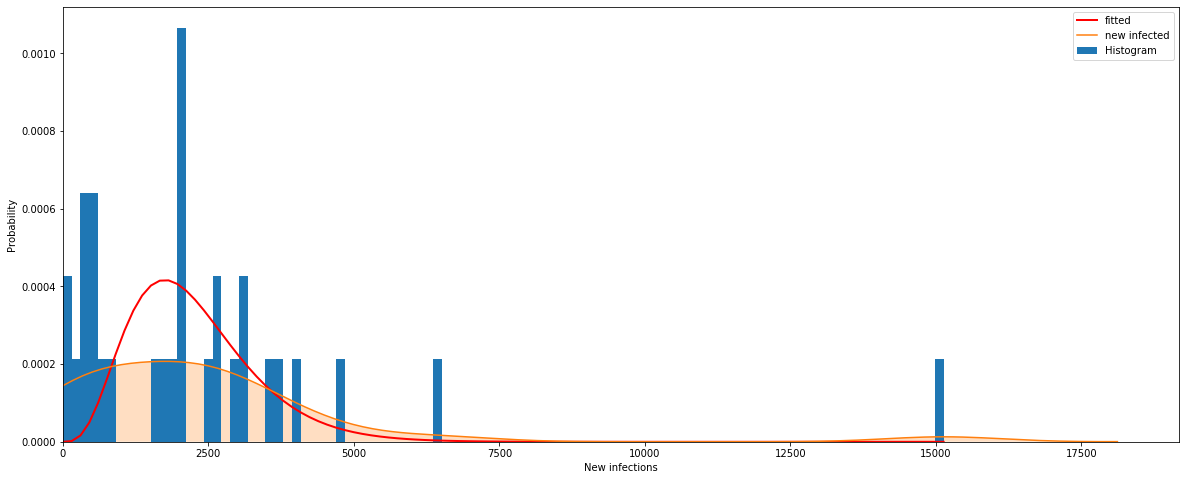

In [10]:
shape, scale = 4, 550 # manual
import scipy.special as sps
fig = plt.figure(figsize=(20,8))

count, gbins, ignored = plt.hist(case['new infected'], bins=100, normed=True, label='Histogram')
y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
plt.plot(gbins, y, linewidth=2, color='r', label='fitted')
sb.kdeplot(case['new infected'], shade=True).set(xlim=(0), label='KDE plot')

plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

#### Some comments about the fitting
- The density plot is **missing some data** because we did not include counts from the earlier days of the outbreak (we have it but it is highly unreliable) 
- therefore the density distribution do not have new infection numbers that is near 0

# MCMC
- Why MCMC?
 - it offers us a robust method to draw samples from our posterior ie. allow us to bootstrap our data (new infection) to test a distribution
 - with the sampled distribution we can use MLE to find the parameters of the distribution
 - since our belief is a gamma distribution, we do the MLE for gamma
 - with the shape and scale parameters of gamma, we create an actual gamma distribution with these parameters, allowing us to forecast/predict samples that fall within the distribution of gamma. 
 - we do not know exactly what tomorrow's new infection number will be. But we can know the mean and variance of the gamma distribution + today's infection number = gives us tomorrow's infection count. 
 - Yes, it doesn't tell us in the future when and what the infection count will be (it doesnt forecast).

### Description
- MCMC
- use Metropolis Hastings' acceptance criterion
- checks for convergence using Gelman-Rubin's ratio

iter: 30000.0
Theta: 1500
Mean of samples: 2190.418348825502, Stddev of samples: 975.6974518277532
Theta: 2000
Mean of samples: 2126.3702739210808, Stddev of samples: 976.4885202933656
Theta: 2500
Mean of samples: 2200.416042387568, Stddev of samples: 896.718091257326
Theta: 3000
Mean of samples: 2193.418000132232, Stddev of samples: 901.093756515636
Theta: 3500
Mean of samples: 2392.019046661459, Stddev of samples: 1061.0683304339914
Gelman Rubin convergence ratio: 1.197930688490338
iter: 65000.0
Theta: 1500
Mean of samples: 2251.5378872058545, Stddev of samples: 1123.6609718572586
Theta: 2000
Mean of samples: 2215.7774239662235, Stddev of samples: 1053.1756975723151
Theta: 2500
Mean of samples: 2249.835220092046, Stddev of samples: 982.3231114010339
Theta: 3000
Mean of samples: 2111.206429853731, Stddev of samples: 963.0170269620651
Theta: 3500
Mean of samples: 2389.560740610795, Stddev of samples: 1187.4621045624451
Gelman Rubin convergence ratio: 1.1882308064307252
iter: 100000.0
T

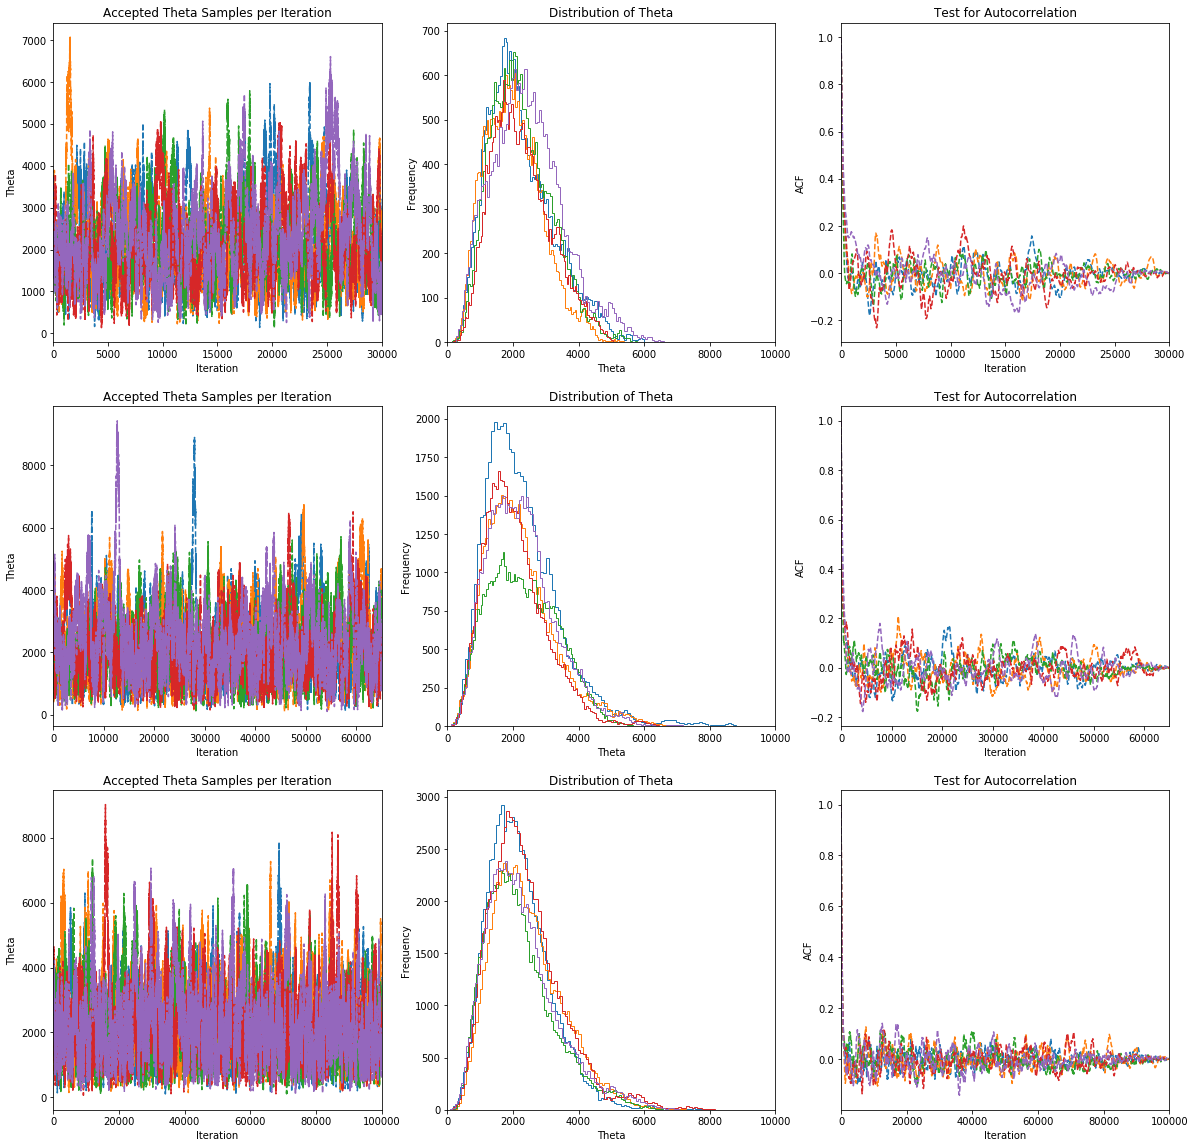

In [11]:
print(shape, scale) # manually chosen

MCMC(shape, scale, niters = np.linspace(3e4,1e5,3), thetas = np.arange(1500, 3501, 500))

## Case 2: Simulate Hubei infection numbers

In [12]:
case_hubei = df[df['Province']=='Hubei']

In [13]:
case_hubei.head(10)

,Province,Country,Date,Confirmed,Deaths,Recovered
13,Hubei,China,2020-01-22,444.0,17,28
51,Hubei,China,2020-01-23,444.0,17,28
84,Hubei,China,2020-01-24,549.0,24,31
125,Hubei,China,2020-01-25,761.0,40,32
169,Hubei,China,2020-01-26,1058.0,52,42
216,Hubei,China,2020-01-27,1423.0,76,45
267,Hubei,China,2020-01-28,3554.0,125,80
319,Hubei,China,2020-01-29,3554.0,125,88
373,Hubei,China,2020-01-30,4903.0,162,90
431,Hubei,China,2020-01-31,5806.0,204,141


In [14]:
case_hubei['new infected'] = case_hubei['Confirmed'].diff().fillna(1)

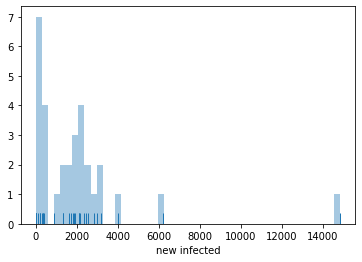

In [15]:
sb.distplot(case_hubei['new infected'], bins=50, kde=False, rug=True)

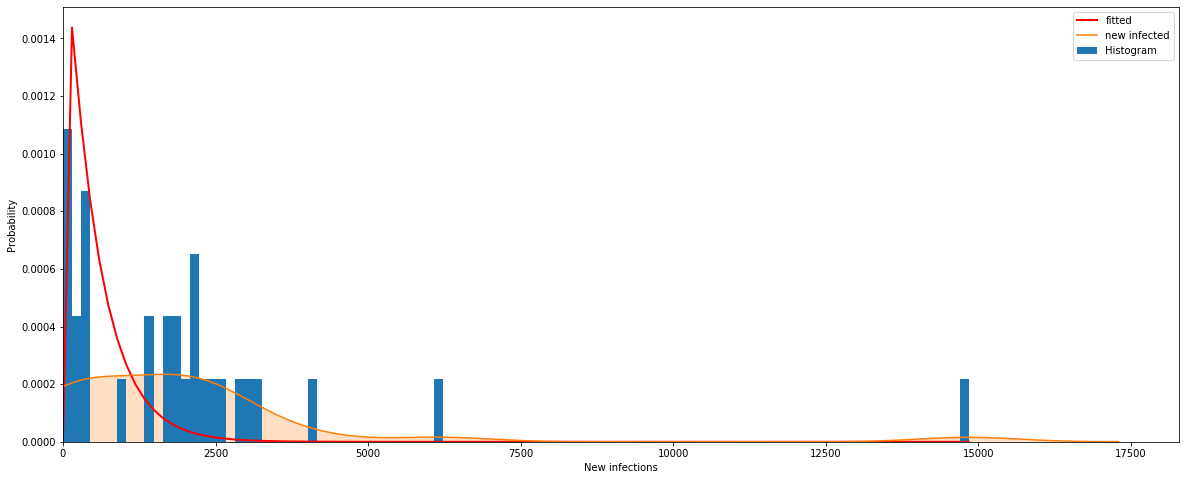

In [16]:
shape, scale = 4, 500 # manual
import scipy.special as sps
fig = plt.figure(figsize=(20,8))

count, gbins, ignored = plt.hist(case_hubei['new infected'], bins=100, normed=True, label='Histogram')
y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
plt.plot(gbins, y, linewidth=2, color='r', label='fitted')
sb.kdeplot(case_hubei['new infected'], shade=True).set(xlim=(0), label='KDE plot')

plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

In [17]:
mu = case_hubei['new infected'].mean()
sigma = case_hubei['new infected'].std()
mu, sigma

(2007.0645161290322, 2765.195676445386)

iter: 30000.0
Theta: 1500
Mean of samples: 547.7794611220347, Stddev of samples: 501.5259846276725
Theta: 2000
Mean of samples: 517.1669909898089, Stddev of samples: 442.971295742799
Theta: 2500
Mean of samples: 564.003911622559, Stddev of samples: 503.07960274820795
Theta: 3000
Mean of samples: 526.5566061805538, Stddev of samples: 475.7345382555834
Theta: 3500
Mean of samples: 547.8434078458042, Stddev of samples: 553.1471475312959
Gelman Rubin convergence ratio: 1.1846706160094127
iter: 65000.0
Theta: 1500
Mean of samples: 530.6099431657801, Stddev of samples: 443.0252502488518
Theta: 2000
Mean of samples: 590.3943235421585, Stddev of samples: 562.3679799014122
Theta: 2500
Mean of samples: 580.9794933709488, Stddev of samples: 552.9242287300442
Theta: 3000
Mean of samples: 563.7311919412912, Stddev of samples: 526.0646173406358
Theta: 3500
Mean of samples: 547.9998456093582, Stddev of samples: 498.7619807333638
Gelman Rubin convergence ratio: 1.185072585615039
iter: 100000.0
Theta: 

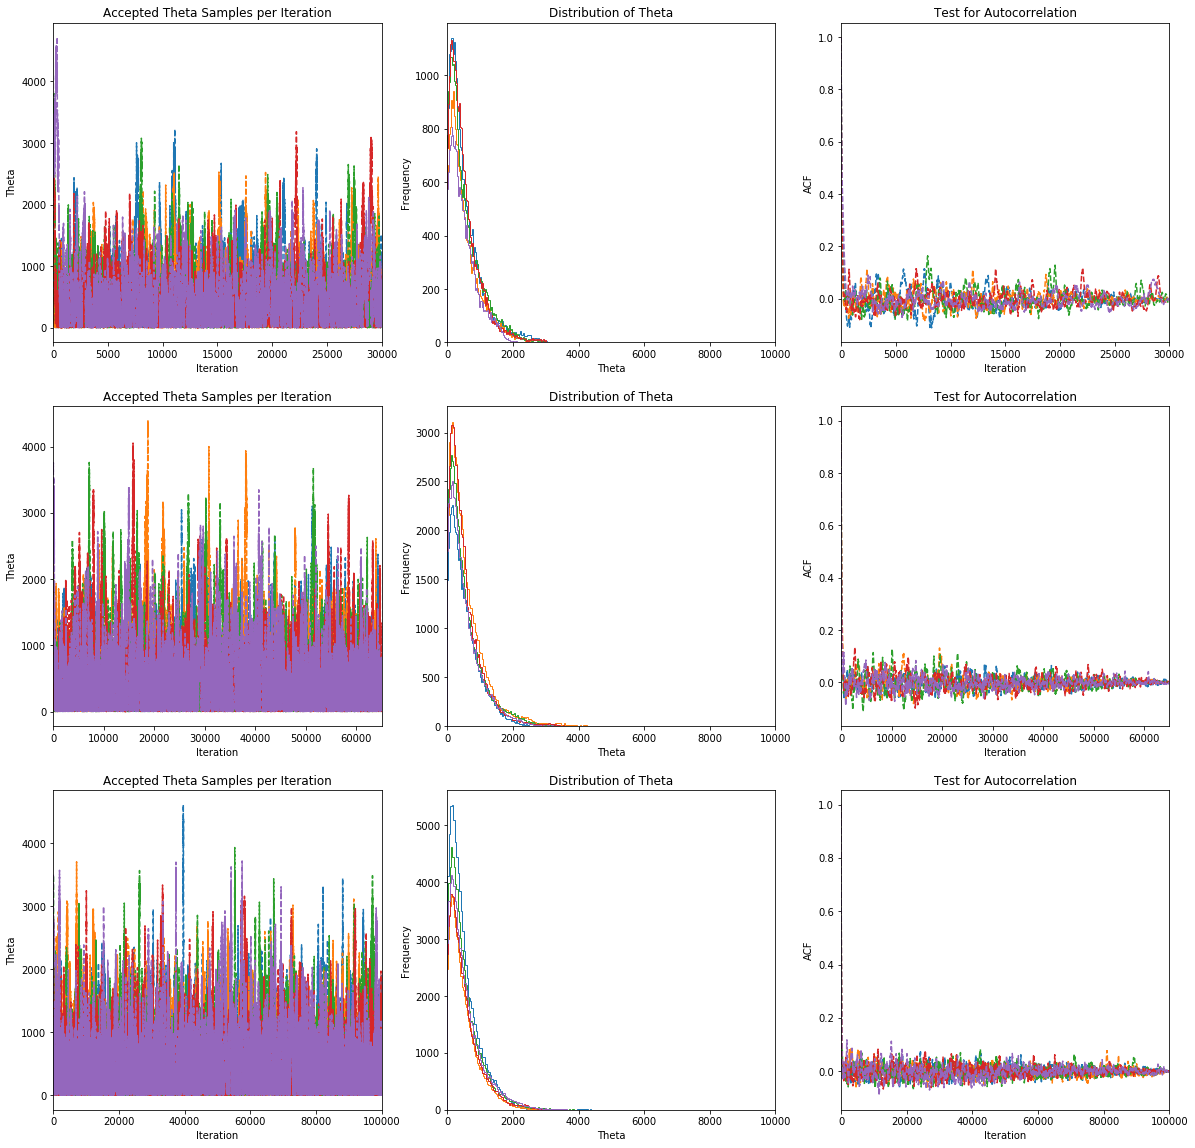

In [18]:
print(shape, scale) # manually chosen

MCMC(shape, scale, niters = np.linspace(3e4,1e5,3), thetas = np.arange(1500, 3501, 500))

## Case 3: Simulate China, ex-Hubei infection numbers

In [19]:
case_exHubei = df[(df['Country']=='China')&(df['Province']!='Hubei')]

In [20]:
case_exHubei = case_exHubei.groupby('Date').agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'}).reset_index()

In [21]:
case_exHubei['new infected'] = case_exHubei['Confirmed'].diff().fillna(1)

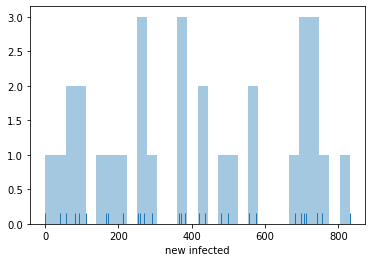

In [22]:
sb.distplot(case_exHubei['new infected'], bins=30, kde=False, rug=True)

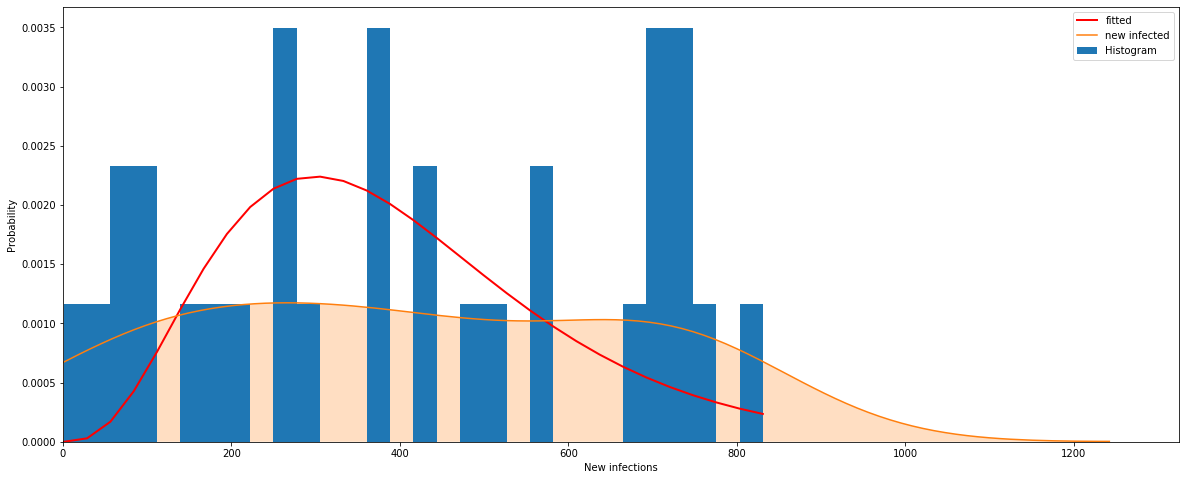

In [23]:
shape, scale = 4, 100 # manual
import scipy.special as sps
fig = plt.figure(figsize=(20,8))

count, gbins, ignored = plt.hist(case_exHubei['new infected'], bins=30, normed=True, label='Histogram')
y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
plt.plot(gbins, y, linewidth=2, color='r', label='fitted')
sb.kdeplot(case_exHubei['new infected'], shade=True).set(xlim=(0), label='KDE plot')

plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

In [24]:
mu = case_exHubei['new infected'].mean()
sigma = case_exHubei['new infected'].std()
mu, sigma

(409.93548387096774, 257.389579623816)

iter: 30000.0
Theta: 100
Mean of samples: 403.4495034973681, Stddev of samples: 193.90976124513014
Theta: 600
Mean of samples: 409.25691735008246, Stddev of samples: 196.11282135611955
Theta: 1100
Mean of samples: 411.7946826639598, Stddev of samples: 204.91917910077674
Theta: 1600
Mean of samples: 419.94783690853416, Stddev of samples: 203.34915069898224
Theta: 2100
Mean of samples: 409.89286509341827, Stddev of samples: 194.31454737415373
Gelman Rubin convergence ratio: 1.1836403807242288
iter: 65000.0
Theta: 100
Mean of samples: 411.21918267365965, Stddev of samples: 190.99029590979325
Theta: 600
Mean of samples: 415.2001487366266, Stddev of samples: 204.0863707457079
Theta: 1100
Mean of samples: 404.8267580937057, Stddev of samples: 193.17762525271777
Theta: 1600
Mean of samples: 407.62126365429185, Stddev of samples: 196.41998300445425
Theta: 2100
Mean of samples: 406.74456550261453, Stddev of samples: 195.64625519874593
Gelman Rubin convergence ratio: 1.183705873556398
iter: 1000

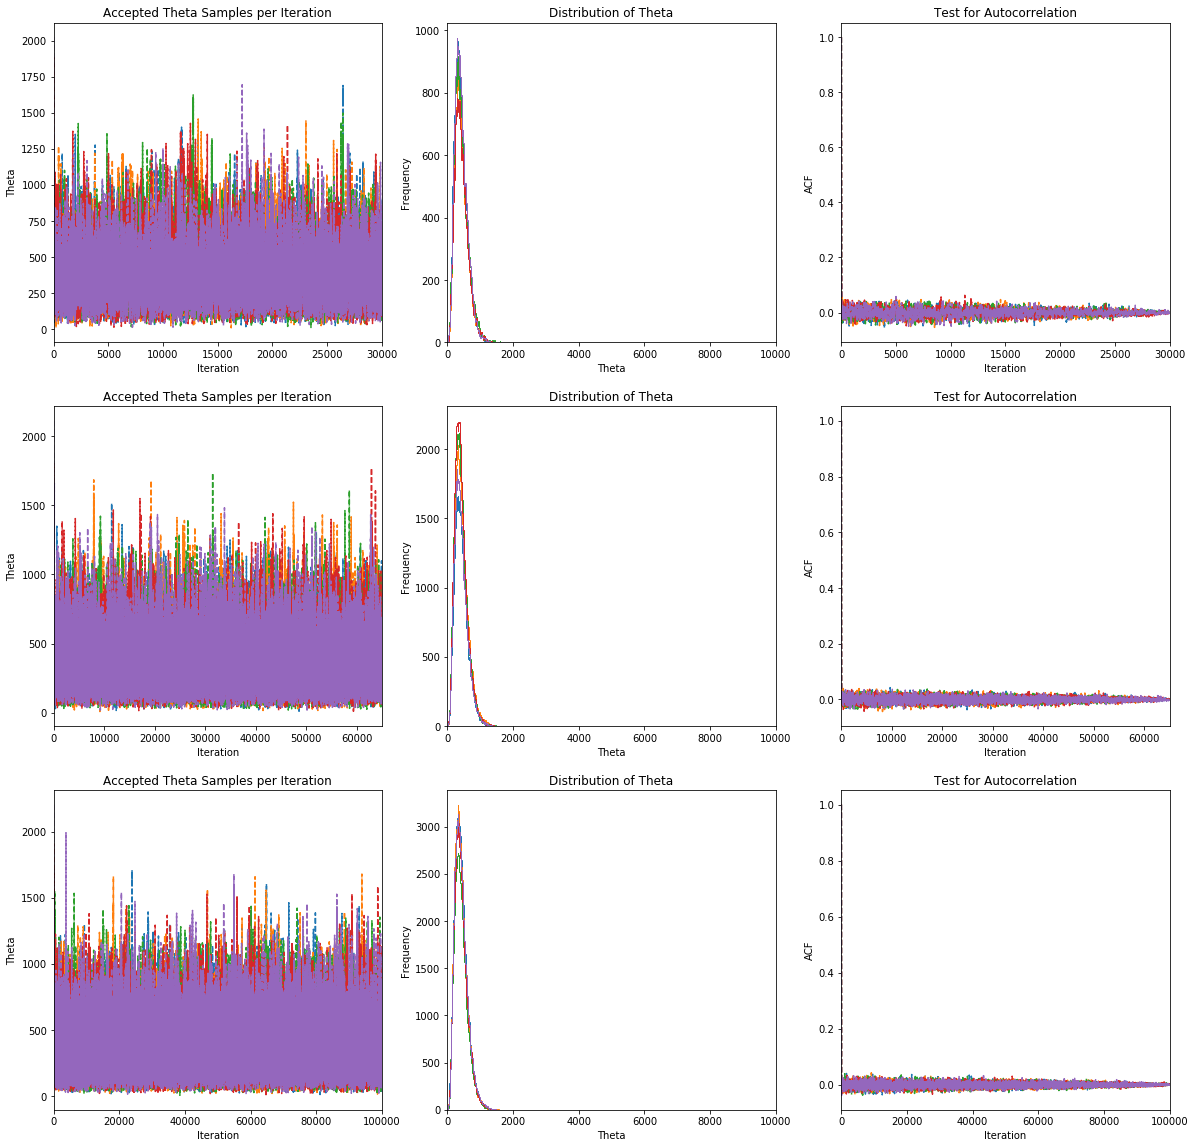

In [25]:
print(shape, scale) # manually chosen

MCMC(shape, scale, niters = np.linspace(3e4,1e5,3), thetas = np.arange(100, 2101, 500))

## Case 4: Simulate ex-China infection numbers

In [3]:
case_exChina = df[(df['Country']!='China')]

In [4]:
case_exChina = case_exChina.groupby('Date').agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'}).reset_index()

In [5]:
case_exChina['new infected'] = case_exChina['Confirmed'].diff().fillna(1)

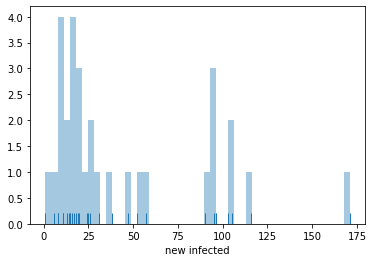

In [6]:
sb.distplot(case_exChina['new infected'], bins=50, kde=False, rug=True)

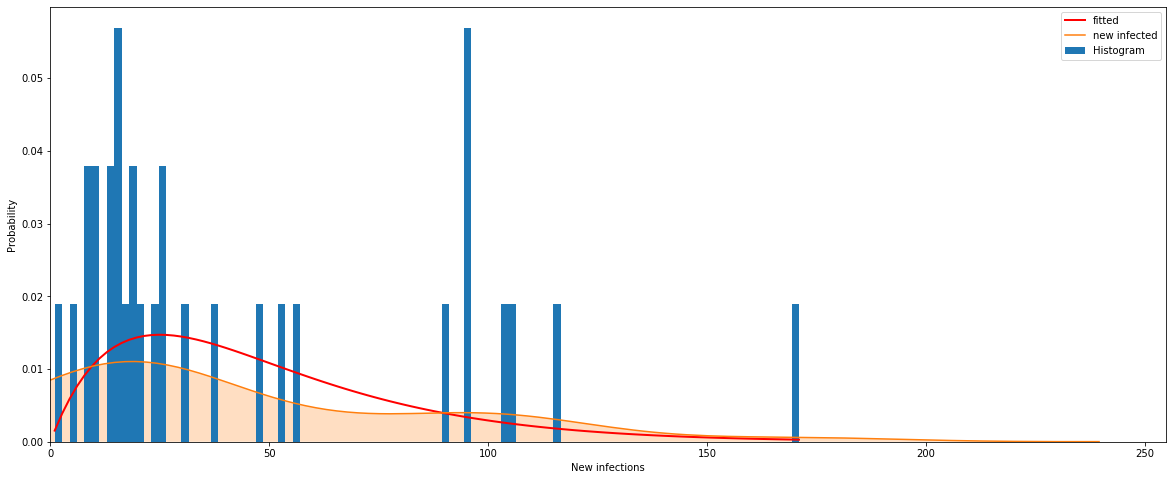

In [25]:
shape, scale = 2, 25 # manual
import scipy.special as sps
fig = plt.figure(figsize=(20,8))

count, gbins, ignored = plt.hist(case_exChina['new infected'], bins=100, normed=True, label='Histogram')
y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
plt.plot(gbins, y, linewidth=2, color='r', label='fitted')
sb.kdeplot(case_exChina['new infected'], shade=True).set(xlim=(0), label='KDE plot')

plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

In [26]:
mu = case_exChina['new infected'].mean()
sigma = case_exChina['new infected'].std()
mu, sigma

(44.0, 42.88278597914708)

2 25
iter: 30000.0
Theta: 10
Mean of samples: 50.13147946292572, Stddev of samples: 32.193438491049584
Theta: 60
Mean of samples: 51.72837337260134, Stddev of samples: 34.37774995941635
Theta: 110
Mean of samples: 50.25514243843604, Stddev of samples: 34.15983962975311
Theta: 160
Mean of samples: 50.875093161792066, Stddev of samples: 34.93931394982625
Theta: 210
Mean of samples: 50.33126598646157, Stddev of samples: 34.41071817170491
Gelman Rubin convergence ratio: 1.183254937906358
iter: 65000.0
Theta: 10
Mean of samples: 52.13526695005097, Stddev of samples: 35.24182782280934
Theta: 60
Mean of samples: 47.20523834106352, Stddev of samples: 30.883972625977588
Theta: 110
Mean of samples: 51.11397701900093, Stddev of samples: 34.879883884995515
Theta: 160
Mean of samples: 51.910526219726194, Stddev of samples: 35.760294531252185
Theta: 210
Mean of samples: 50.54696802170383, Stddev of samples: 35.22952992351941
Gelman Rubin convergence ratio: 1.1853074666486263
iter: 100000.0
Theta: 10

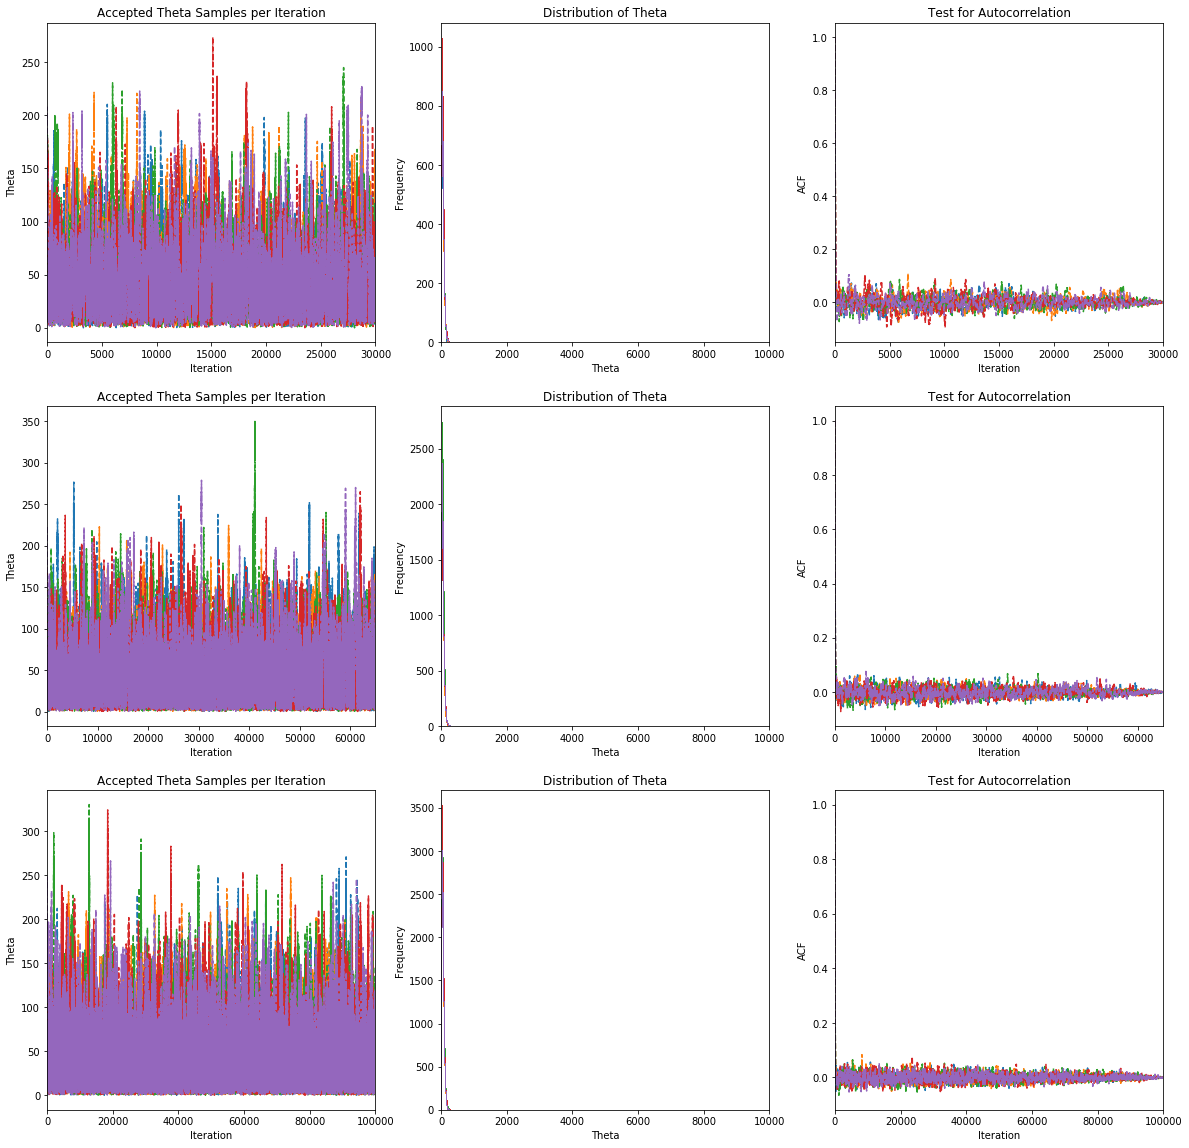

In [28]:
print(shape, scale) # manually chosen
MCMC(shape, scale, sigma=10, niters = np.linspace(3e4,1e5,3), thetas = np.arange(10, 260, 50))

In [ ]:
class mh:
    '''
    Metropolis Hasting pseudo algorithm can be found at: http://www.mit.edu/~ilkery/papers/MetropolisHastingsSampling.pdf
    
    The Metropolis Hastings method runs for N iterations with different starting points - thetas (plausible values of the mean).
    It completes after N samples are accepted and returns those samples.
    
    This mcmc algorithm's target (proposal) is a gamma distribution and the transition is a normal distribution (random perturbation)
    
    reference: https://people.duke.edu/~ccc14/sta-663/MCMC.html
    
    '''
    def __init__(self, niters: int, theta: int, sigma: float, target, t_param1, t_param2=None):
        self.niters = niters
        self.theta = theta
        self.sigma = sigma
        self.target = target
        self.shape = t_param1 # shape
        self.scale = t_param2 # scale
        self.samples = []
        self.theta_p = None

    def _target_model(self, theta):
#         return self.target.pdf(theta, self.shape, scale=self.scale)
    
    def run(self):
        print("Theta: %s" %self.theta)
        while len(self.samples) < self.niters:
            self.theta_p = max(self.theta + np.random.normal(0, self.sigma), 0) # q(x), if negative, assign 0

            T_next = self._target_model(self.theta_p) # π(x_cand) since we are using a symmetric transition probability, we can cancel away the transition term
            T_prev = self._target_model(self.theta)  #  π(x(i−1)) since we are using a symmetric transition probability, we can cancel away the transition term

            a = min(1, T_next/T_prev)
            u = np.random.uniform()
            if u < a:
                self.theta = copy.copy(self.theta_p)
                self.samples.append(self.theta)
           
        print("Mean of samples: %s, Stddev of samples: %s" %(np.sum(self.samples)/len(self.samples), np.std(self.samples)))
        return self.samples

In [ ]:
from scipy.stats import gamma, poisson

niters = niters
cnt = 1

fig = plt.figure(figsize=(20,20))

for i in range(len(niters)):
    print("iter: %s" %niters[i])

    # select a sigma for the algo, 
    # a range too wide gives you lower chances of accepting samples but allows more room for the candidate data to roam
    # a range too narrow gives you higher chance of accepting samples but samples may not converge
    sigma = sigma

    # select different starting points for mu based on its range
    thetas = thetas
    sampless = [mh(niters[i], mu_, sigma, gamma, shape, scale).run() for mu_ in thetas]

    # Samples plot
    ax = fig.add_subplot(3,3,i+cnt)
    for samples in sampless:    
        ax.plot(samples, '--')
    ax.set_xlim([0, niters[i]])
    ax.set_ylabel('Theta')
    ax.set_xlabel('Iteration')
    ax.set_title('Accepted Theta Samples per Iteration')
    cnt += 1

    # Distribution plot
    ax = fig.add_subplot(3,3,i+cnt)
    last_n_samples = int(niters[i] * 0.8)
    for samples in sampless:
        ax.hist(samples[-last_n_samples:], bins=100, histtype='step', label=f'{niters[i]}')
    ax.set_xlim([0, 10000*sigma/100])
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Theta')
    ax.set_title('Distribution of Theta')
    cnt += 1

    # Auto-correlation plot
    ax = fig.add_subplot(3,3,i+cnt)
    for samples in sampless:
        ax.plot(mc.autocorr.function_1d(samples), '--')
    ax.set_xlim([0, niters[i]])
    ax.set_ylabel('ACF')
    ax.set_xlabel('Iteration')
    ax.set_title('Test for Autocorrelation')
    print("Gelman Rubin convergence ratio: %s" %GelmanRubinTest(len(thetas), len(sampless[0]), sampless))

plt.show()

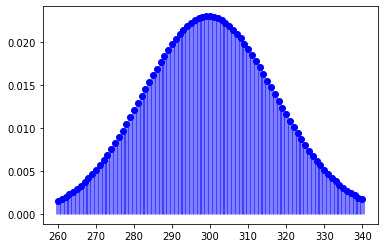

In [57]:
from scipy.stats import poisson
fig, ax = plt.subplots(1, 1)
mu = 300 # 0.6
mean, var, skew, kurt = poisson.stats(mu, moments='mvsk')
x = np.arange(poisson.ppf(0.01, mu),
              poisson.ppf(0.99, mu))
ax.plot(x, poisson.pmf(x, mu), 'bo', label='poisson pmf')
ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)

In [41]:
poisson.pmf(x, mu)

array([3.42369819e-18, 7.84199135e-13, 2.33274098e-09, 9.09854432e-08,
       1.89963333e-06, 2.71108844e-11, 2.36576558e-05, 2.33274098e-09,
       7.33949242e-07, 8.37633424e-03, 6.11947309e-04, 2.89499138e-08,
       2.71108844e-11, 3.47697335e-04, 2.66890633e-07, 4.20459368e-02,
       2.77928819e-02, 1.03560314e-03, 4.64354815e-06, 4.63584694e-12,
       1.07534799e-05, 5.25594776e-02, 2.66890633e-07, 9.12224563e-03,
       4.26430137e-10, 1.01145751e-11, 1.00220254e-19, 1.48219741e-14,
       4.63584694e-12, 2.62777855e-15, 6.72469157e-48])

In [ ]:
https://github.com/tminka/fastfit/blob/master/gamma_fit.m

## References

In [ ]:
import copy

prev_draw = np.random.normal(mu,sigma) #Initialize x(0) ∼ q(x)
sample = []
steps = 1000

for i in range(1, steps):
    if i == 0:
        prev_draw = copy.copy(mu)
    else:
        current = np.random.normal(mu,sigma)
        candidate = transition_model(current, prev_draw) #Propose: x_cand ∼ q(x(i)|x(i−1))
        print("%s, current: %s candidate: %s" %(i,current,candidate))
        T_next = target_model(candidate) # π(x_cand)q(x(i−1)|x_cand)
        T_prev = target_model(current) #   π(x(i−1))q(x_cand|x(i−1))
        a = min(1, max(T_next / T_prev,0)) # Acceptance Probability

        if a > np.random.uniform(0, 1): # u ∼ Uniform (u; 0, 1)
            # Update state
            print("accepted, current: %s candidate: %s" %(current,candidate))
            current = copy.copy(candidate) # Accept the proposal: x(i) ← x_cand
            sample.append(current)
print('Accept ratio:', float(len(sample)) / steps)

In [ ]:
# P(x) : Target distribution
def P(x1, x2, b):
    return np.exp(-0.5 * (x1**2 - 2*b*x1*x2 + x2**2))


# Q(x) : Proposal distribution
def Q(c, mu1, mu2, sigma):
    return (c[0] * np.random.normal(mu1, sigma), c[1] * np.random.normal(mu2, sigma))

def metropolisHastings(mu, sigma):
    current = (10, 10)
    sample = []
    sample.append(current)
    accept_ratio = []

    for i in range(N):
        candidate = Q(current, mu1, mu2, sigma)

        T_prev = P(current[0], current[1], b)
        T_next = P(candidate[0], candidate[1], b)
        a = T_next / T_prev

        if a > 1 or a > np.random.uniform(0, 1):
            # Update state
            current = copy.copy(candidate)
            sample.append(current)
            accept_ratio.append(i)

    print('Accept ratio:', float(len(accept_ratio)) / N)
    return np.array(sample)

Text(0, 0.5, 'Frequency')

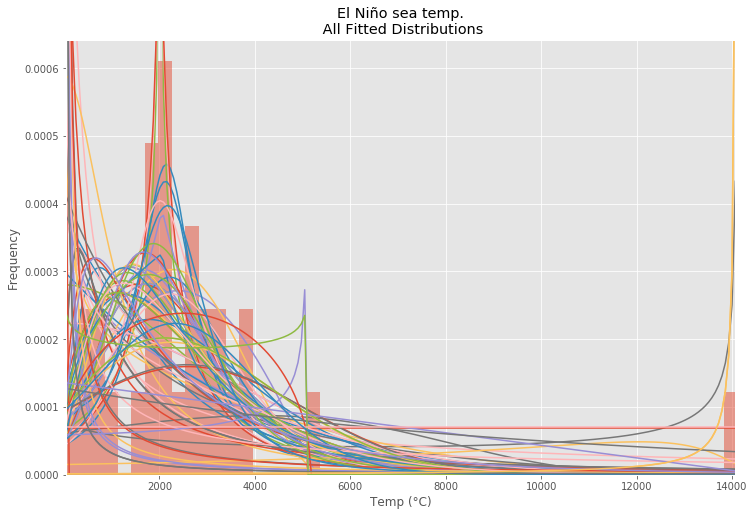

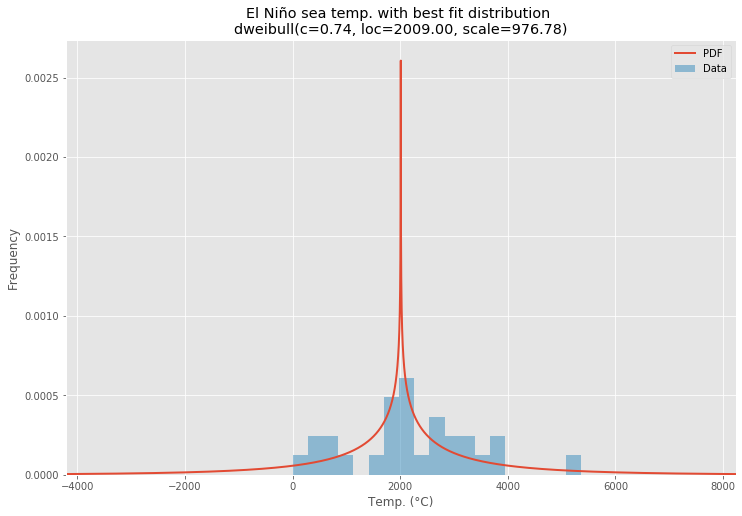

In [30]:
import scipy.stats as st


import matplotlib
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = case['new infected']

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [3]:
df_blanker = pd.read_csv('./csv/DXYArea.csv')
print(df_blanker.shape)
# df_blanker = df_blanker[df_blanker['provinceEnglishName']=='Hubei']
df_blanker['date'] = df_blanker['updateTime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').date())
df_daily_max_datetime = df_blanker.groupby(['date','cityName']).agg({'updateTime':'max'}).reset_index()
df_daily_max = pd.merge(df_daily_max_datetime, df_blanker, on=['updateTime','date','cityName'], how='inner')
covid_cn = df_daily_max.groupby('date').agg({'city_confirmedCount':'sum'}).reset_index()
covid_cn = covid_cn.iloc[:-1 ,:] ## remove today's data as it will not be complete
covid_cn.columns = ['date','infected']
print(covid_cn.shape)
covid_cn['new infected'] = covid_cn['infected'].diff().fillna(1)

(44066, 15)
(25, 2)
